In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("../files_report.csv")
df = df[~df.isna().any(axis=1) & (df.file_size > 0)]

In [9]:
duplicates = df[df.duplicated(subset='file_md5', keep=False)].sort_values(by='file_size', ascending=False)

In [10]:
import math
def convert_size(size_bytes):
    """Convert bytes to a readable format (KB, MB, GB, etc.)."""
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

In [11]:
duplicates['file_size_h'] = duplicates['file_size'].apply(convert_size)

In [12]:
import os
duplicates['folder'] = duplicates['file_path'].apply(lambda x: os.path.dirname(x))

In [27]:
dupl_records = duplicates.groupby(['file_md5', 'file_size_h'], group_keys=False).apply(lambda x: x[['file_path', 'folder']].to_dict(orient='records')).to_dict()


/var/folders/7j/12w744p179x731mgr1zcql2w0000gn/T/ipykernel_72776/3395358774.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dupl_records = duplicates.groupby(['file_md5', 'file_size_h'], group_keys=False).apply(lambda x: x[['file_path', 'folder']].to_dict(orient='records')).to_dict()


In [22]:
import os

def find_common_prefix(paths):
    """Find the largest common prefix (base folder) in a list of paths."""
    if not paths:
        return ""
    
    # Split the paths into lists of directories
    split_paths = [p.split(os.sep) for p in paths]
    
    # Use zip to transpose the list of lists and iterate over corresponding parts
    common_parts = []
    for parts in zip(*split_paths):
        if all(part == parts[0] for part in parts):
            common_parts.append(parts[0])
        else:
            break
    
    # Join the common parts back into a single path
    return os.sep.join(common_parts)

In [32]:
import os

def find_common_prefix(paths):
    """Find the largest common prefix (base folder) in a list of paths."""
    if not paths:
        return ""
    
    # Split the paths into lists of directories
    split_paths = [p.split(os.sep) for p in paths]
    
    # Use zip to transpose the list of lists and iterate over corresponding parts
    common_parts = []
    for parts in zip(*split_paths):
        if all(part == parts[0] for part in parts):
            common_parts.append(parts[0])
        else:
            break
    
    # Join the common parts back into a single path
    return os.sep.join(common_parts)

# Iterate over the groups and print the paths with highlighted common base folder
for k, v in dupl_records.items():
    md5_short = k[0][:6]  # First 6 characters of the MD5 hash
    size_h = k[1]  # Human-readable file size
    
    # Extract file paths from the records
    paths = [r['file_path'] for r in v]

    # Find the common base folder
    common_prefix = find_common_prefix(paths)
    common_prefix_length = len(common_prefix)
    
    # Print MD5 hash, size, and common prefix
    print(f"MD5: {md5_short} Size: {size_h}")
    print(f"Common: {common_prefix}")

    for i, r in enumerate(v):
        # Extract the remaining part of the folder and file base name
        folder_remainder = r['folder'][len(common_prefix):].lstrip(os.sep)
        file_base_name = os.path.basename(r['file_path'])

        # Print the details
        print(f"  {i+1}. Folder: {folder_remainder}")
        print(f"     FileName: {file_base_name}")

    print()


MD5: ('00a989d9a58de3a7e294631061418125', '1.43 MB') Size: 1.43 MB
  Common Prefix: /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power Electronics Lab
  1. Remaining Folder: Lab Record
     File Base Name: DSC02861.JPG
  2. Remaining Folder: NED mohan_PE/lab record
     File Base Name: DSC02861.JPG

MD5: ('01ec8db3d8fdccb4f97af60654f9ad95', '2.07 MB') Size: 2.07 MB
  Common Prefix: /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems
  1. Remaining Folder: 
     File Base Name: IMG_20150903_215753_HDR (1).jpg
  2. Remaining Folder: 
     File Base Name: IMG_20150903_215753_HDR.jpg

MD5: ('01ed1e260cc2df64c3ea586d5fb511ad', '1.46 MB') Size: 1.46 MB
  Common Prefix: /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems
  1. Remaining Folder: 
     File Base Name: IMG_20150903_215429_HDR.jpg
  2. Remaining Folder: 
     File Base Name: IMG_20150903_215429_HDR (1).jpg

MD5: ('02d7c9b59e30d49fad4fc9700b7229a7', '1.32 M

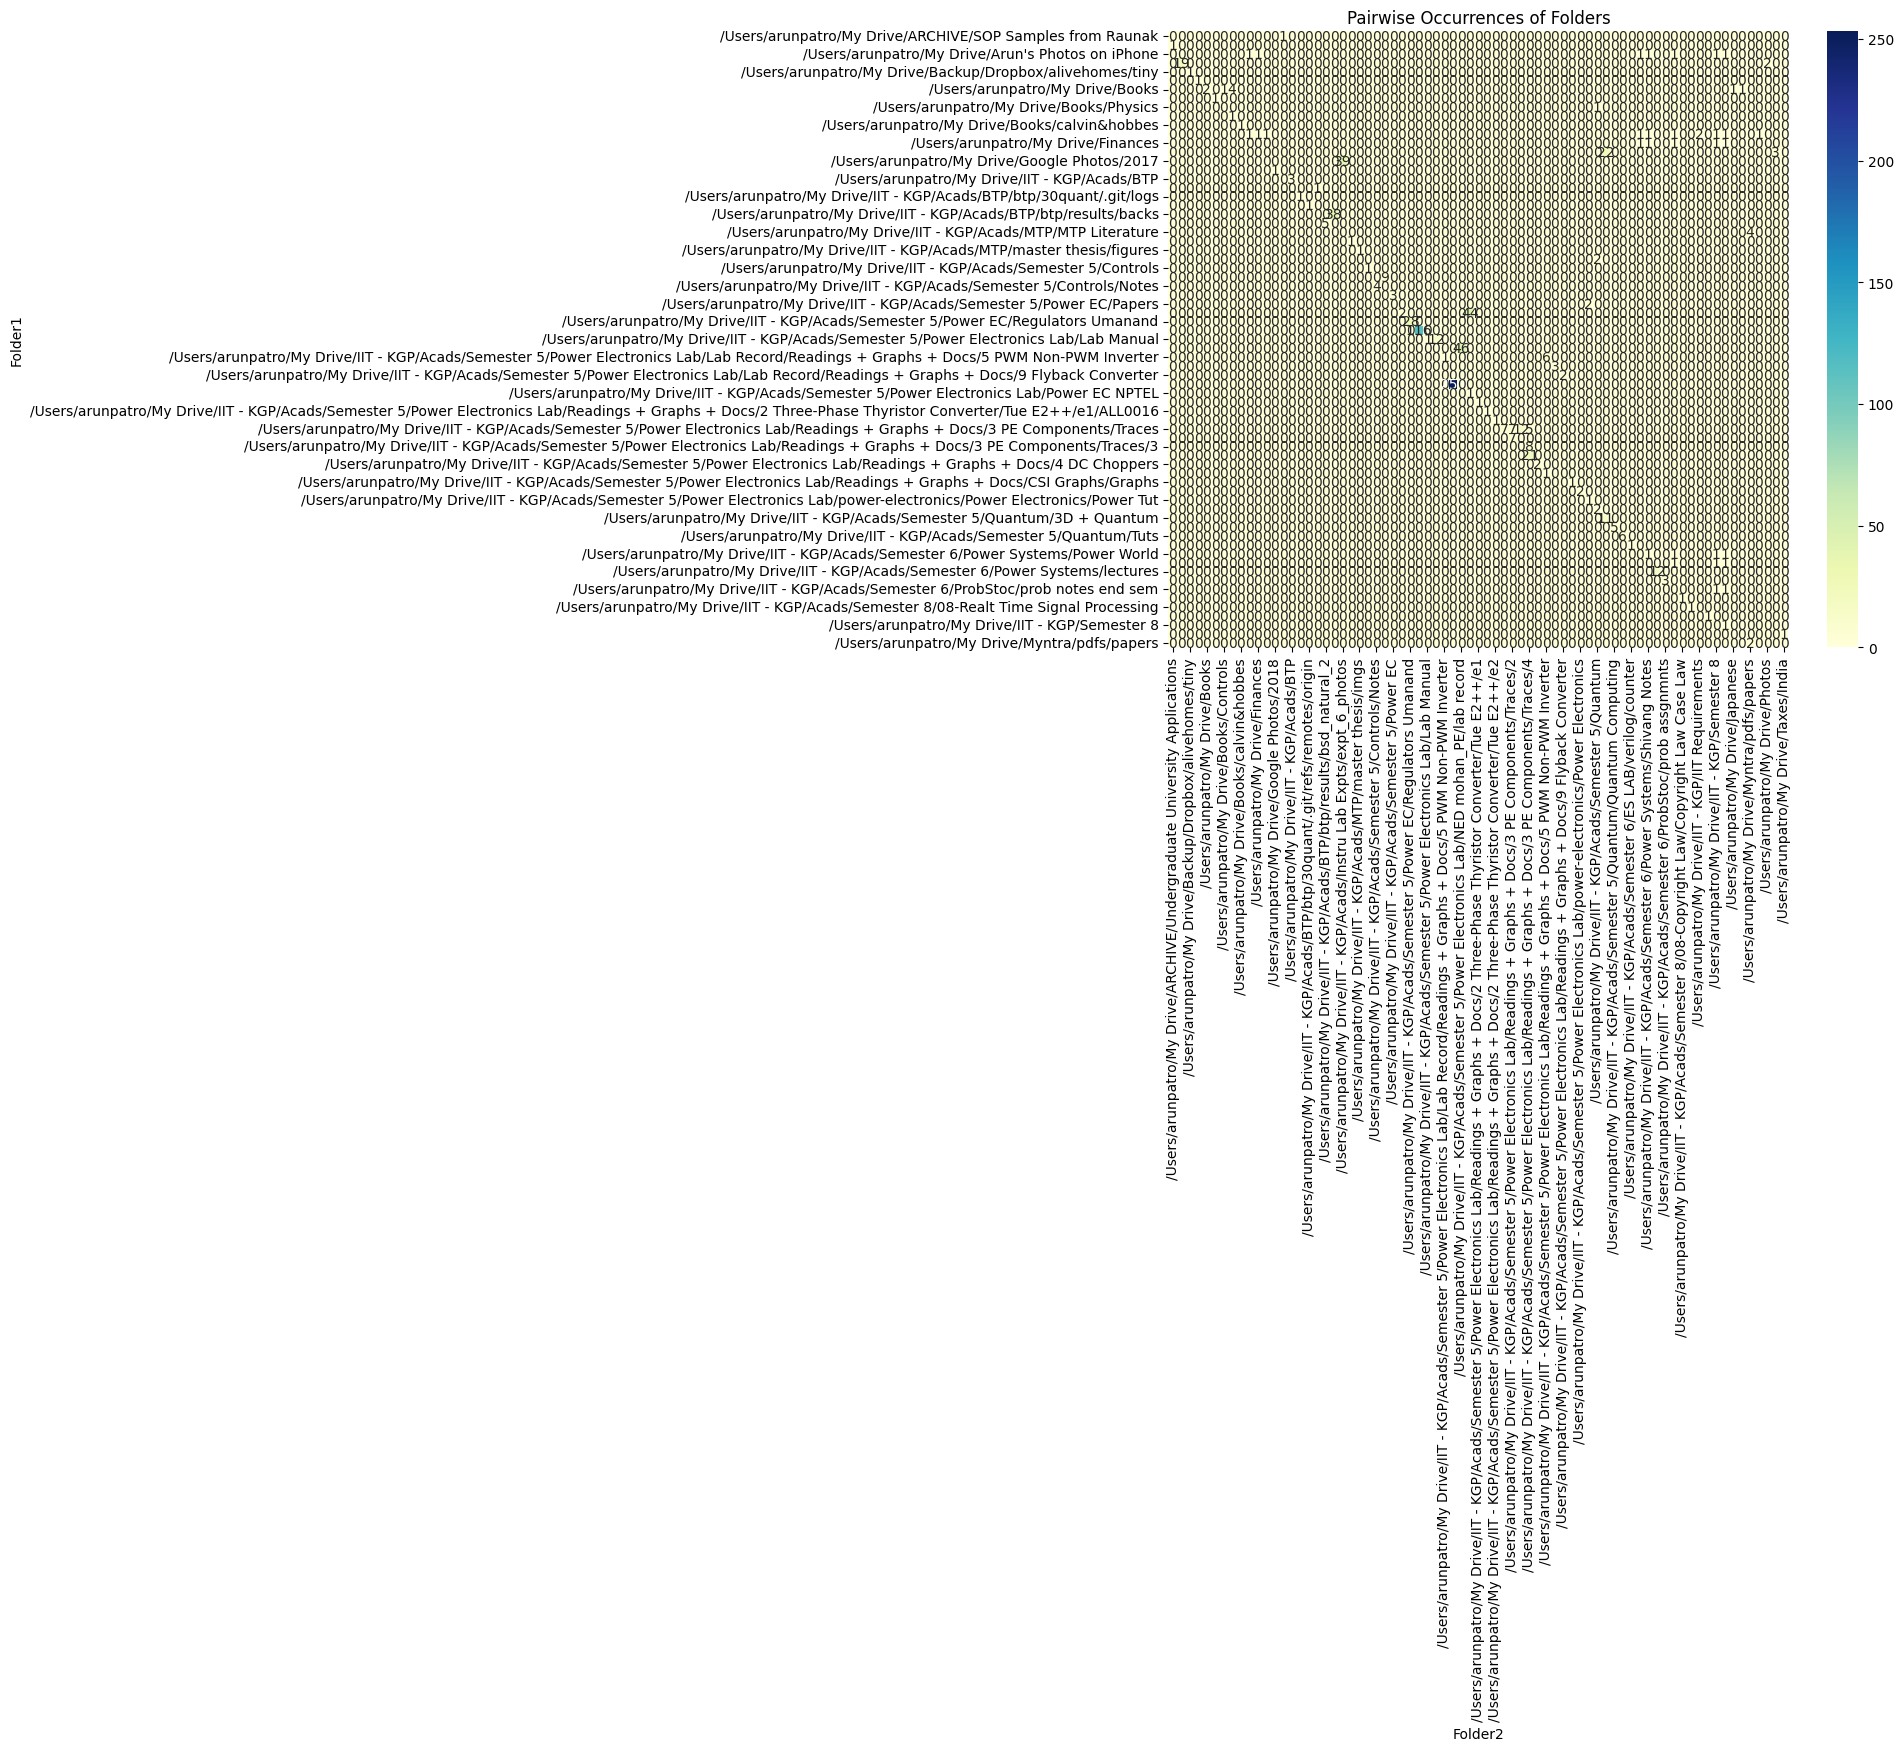

In [21]:
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

# def plot_pairwise_occurrences(aggregated_duplicates):
aggregated_duplicates = agg
"""Plot pairwise occurrences of base folders."""
pairwise_counts = {}

for folders in aggregated_duplicates['folder']:
    if len(folders) > 1:
        for combo in combinations(folders, 2):
            sorted_combo = tuple(sorted(combo))
            if sorted_combo in pairwise_counts:
                pairwise_counts[sorted_combo] += 1
            else:
                pairwise_counts[sorted_combo] = 1

# Create a DataFrame from the pairwise_counts dictionary
pairwise_df = pd.DataFrame(pairwise_counts.items(), columns=['Pair', 'Count'])
pairwise_df[['Folder1', 'Folder2']] = pd.DataFrame(pairwise_df['Pair'].tolist(), index=pairwise_df.index)

# Pivot the DataFrame to create a matrix format
pairwise_matrix = pairwise_df.pivot(index="Folder1", columns="Folder2", values="Count").fillna(0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_matrix, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Pairwise Occurrences of Folders")
plt.show()

In [23]:
pairwise_df.to_csv('pairwise.csv', index=False)

In [6]:
import pandas as pd

df = pd.read_csv('pairwise.csv')

df['self_ref'] = df['Folder1'] == df['Folder2']
df.sort_values(by='Count', ascending=False)

,Pair,Count,Folder1,Folder2,self_ref
98,('/Users/arunpatro/My Drive/IIT - KGP/Acads/Se...,253,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,True
1,('/Users/arunpatro/My Drive/IIT - KGP/Acads/Se...,116,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,True
0,('/Users/arunpatro/My Drive/IIT - KGP/Acads/Se...,46,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,False
6,('/Users/arunpatro/My Drive/IIT - KGP/Acads/Se...,44,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,/Users/arunpatro/My Drive/IIT - KGP/Acads/Seme...,False
2,('/Users/arunpatro/My Drive/Google Photos/2017...,39,/Users/arunpatro/My Drive/Google Photos/2017,/Users/arunpatro/My Drive/IIT - KGP/Acads/Inst...,False
...,...,...,...,...,...
101,"('/Users/arunpatro/My Drive/Certificates', '/U...",1,/Users/arunpatro/My Drive/Certificates,/Users/arunpatro/My Drive/Certificates,True
102,"('/Users/arunpatro/My Drive/Books/Power EC', '...",1,/Users/arunpatro/My Drive/Books/Power EC,/Users/arunpatro/My Drive/Books/Power EC,True
103,('/Users/arunpatro/My Drive/ARCHIVE/Undergradu...,1,/Users/arunpatro/My Drive/ARCHIVE/Undergraduat...,/Users/arunpatro/My Drive/ARCHIVE/Undergraduat...,True
104,('/Users/arunpatro/My Drive/IIT - KGP/IIT Requ...,1,/Users/arunpatro/My Drive/IIT - KGP/IIT Requir...,/Users/arunpatro/My Drive/IIT - KGP/IIT Requir...,False


In [15]:
agg = duplicates.groupby('file_md5').agg({'folder': list}).reset_index()

# grouped_duplicates = duplicates.sort_values(by='file_size', ascending=False).groupby('file_md5')

# # Aggregate base folders into a list
# aggregated_duplicates = grouped_duplicates.agg({
#     'file_path': list,
#     'file_size': 'sum',
#     'base_folder': lambda x: list(set(x))
# })

In [29]:
duplicates.to_csv("duplicates.csv", index=False)

In [24]:
grouped_duplicates = duplicates.sort_values(by='file_size', ascending=False).groupby('file_md5')

# Iterate over groups and display file paths and sizes
for md5, group in grouped_duplicates:
    print(f"\nMD5 Hash: {md5}")
    print(f"Total Size: {convert_size(group['file_size'].sum())}")
    print("File Paths:")
    for idx, row in group.iterrows():
        print(f"  {row['file_path']} - {row['file_size_h']}")


MD5 Hash: 00a989d9a58de3a7e294631061418125
Total Size: 2.85 MB
File Paths:
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power Electronics Lab/Lab Record/DSC02861.JPG - 1.43 MB
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power Electronics Lab/NED mohan_PE/lab record/DSC02861.JPG - 1.43 MB

MD5 Hash: 01ec8db3d8fdccb4f97af60654f9ad95
Total Size: 4.15 MB
File Paths:
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems/IMG_20150903_215753_HDR (1).jpg - 2.07 MB
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems/IMG_20150903_215753_HDR.jpg - 2.07 MB

MD5 Hash: 01ed1e260cc2df64c3ea586d5fb511ad
Total Size: 2.93 MB
File Paths:
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems/IMG_20150903_215429_HDR (1).jpg - 1.46 MB
  /Users/arunpatro/My Drive/IIT - KGP/Acads/Semester 5/Power EC/Vinit Chugh Pre Midsems/IMG_20150903_215429_HDR.jpg - 1.46 MB

MD5 Hash: 02d7c9b59e30d4